# Simple LangGraph SQL Agent using MessageGraph

In [1]:
# %load_ext lab_black

## Imports

In [21]:
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_experimental.llms.ollama_functions import (
    OllamaFunctions,
    convert_to_ollama_tool,
)
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import MessageGraph, END
from langgraph.prebuilt import ToolNode
from IPython.display import display, HTML, Image

## Load the database

In [3]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

## Setup the LLM using OllamaFunctions

In [4]:
llm = OllamaFunctions(model="llama3", format="json", temperature=0)

## Prepare the SQL tools from SQLDatabaseToolkit

In [5]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm, use_query_checker=True)
tools = toolkit.get_tools()

## Bind LLM with SQL tools

In [6]:
llm_with_tools = llm.bind_tools(tools)

## Prepare the Prompt Template

In [7]:
SQL_PREFIX = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.
You have access to the following tools:"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SQL_PREFIX),
        ("human", "{input}")
    ]
)

## Create the oracle LCEL chain (this [oracle](https://en.wikipedia.org/wiki/Oracle) and not this [Oracle](https://en.wikipedia.org/wiki/Oracle_Database))

In [8]:
oracle_chain = prompt | llm_with_tools

### Create a Message Graph builder

In [9]:
builder = MessageGraph()

### Create oracle node for graph agent

In [10]:
def oracle_node(state):
    last_message = state[-1]
    return oracle_chain.invoke({"input": last_message.content})

### Create tools node for graph agent

In [11]:
tools_node = ToolNode(tools)

### Add nodes to the graph builder

In [12]:
builder.add_node("oracle_node", oracle_node)
builder.add_node("tools_node", tools_node)

### Connect notes with edges

In [13]:
builder.add_edge("oracle_node", "tools_node")
builder.add_edge("tools_node", END)

### Set entry point into the graph agent

In [14]:
builder.set_entry_point("oracle_node")

### Compile the graph into an agent

In [15]:
graph = builder.compile()

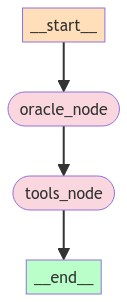

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Test the LangGraph SQL Agent

In [16]:
result = graph.invoke("how many tables I have in the database?")
print(result[-1].content)

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track


In [17]:
result = graph.invoke("what is the schema of the Artist table?")
print(result[-1].content)


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [18]:
result = graph.invoke("Show the first 5 records of the Artist table")
print(result[-1].content)

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]
